In [1]:
import numpy as np
import pandas as pd

import Bio
from Bio import SeqIO, AlignIO
from Bio import Entrez
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import os, re, io, random, string
import re
from Bio.Align import MultipleSeqAlignment

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# PAML

Copied all `.ctl` files from the tar file for Linux/Mac <a href="http://abacus.gene.ucl.ac.uk/software/#downloads-and-installation-2" target="_blank">here</a>.

# HyPhy

## Data input format (easiest of the options):

Two separate files with the alignment and phylogeny each. 

Most standard alignment formats are accepted (FASTA, phylip, etc.), and the phylogeny should be Newick-formatted.

Launch with `hyphy -i`

Tutorial: http://hyphy.org/tutorials/CL-prompt-tutorial/

# Methods

Good explanations: https://stevenweaver.github.io/hyphy-site/methods/selection-methods

## BUSTED

BUSTED (Branch-Site Unrestricted Statistical Test for Episodic Diversification) provides a gene-wide (not site-specific) test for positive selection by asking whether a gene has experienced positive selection at at least one site on at least one branch.

<ul>
    <li>Can specify which branches to test or do all of them.</li>
    <li> It is gene-wide, not site-specific, so probably not desired for our purposes?</li>
</ul>


## FEL and SLAC

Infer dN and dS substitutions rates on a per-site basis. Assume that selection pressure for each site is constant along the entire phylogeny. This is probably not true in this case because the Nipah virus sequences come from different organisms with different immune behavior. <b>How do we account for this without a temporal analysis?</b>

SLAC uses maximum-likelihood and counting approaches. FEL is a fixed effects model.  

# Fasta files can not have stop codons in them, so generate new files for them

Located at `seq_for_analysis/G_no_stop_codons.fasta` and `seq_for_analysis/P_no_stop_codons.fasta`

`seq_for_analysis/P_no_stop_codons.fasta` also does not contain isolate MK575063, which has a premature stop codon, so it has been excluded from HyPhy analyses.

In [122]:
# G_seq = [(seq_record.id, seq_record.seq) for seq_record in SeqIO.parse("seq_for_analysis/G_deduplicated.fasta", "fasta")]
# P_seq = [(seq_record.id, seq_record.seq) for seq_record in SeqIO.parse("seq_for_analysis/P_deduplicated_no_nonsense.fasta", "fasta")]
# len(G_seq), len(P_seq)

# Convert sequences to Phylip format for Phyml

In [124]:
# aln_P = AlignIO.parse('seq_for_analysis/P_deduplicated_no_nonsense.fasta', "fasta")
# AlignIO.write(aln_P, 'seq_for_analysis/P_deduplicated_no_nonsense.phy', 'phylip')

# aln_G = AlignIO.parse('seq_for_analysis/G_deduplicated.fasta', "fasta")
# AlignIO.write(aln_G, 'seq_for_analysis/G_deduplicated.phy', 'phylip')

1

## More metadata: clade (country), organism, date, etc. to use FEL-Contrast

In [4]:
# supplemental table from the Whitmer et al paper with metadata
new_metadata = pd.read_excel("sequences/Whitmer_SuppTable_1_V8.xlsx", header=3).iloc[:, 1:]

metadata_all = pd.read_csv("metadata_all.csv")

In [5]:
def get_ncbi_accessions(id_list):
    
    Entrez.email='skulkarni@g.harvard.edu'

    # search Genbank, returns accession numbers
    handle=Entrez.esearch(db='nucleotide', retmax=1000, term=",".join(id_list), idtype="acc") 
    record = Entrez.read(handle)
    
    handle.close()
    fetch = Entrez.efetch(db='nucleotide', id=",".join(record['IdList']), rettype='gb', retmode='text')
    gb=fetch.read()
    
    # the first one is an empty string because it's what comes before the first locus
    found_seq = list(gb.split("LOCUS"))[1:]
    print(f"Found {len(found_seq)} out of {len(id_list)} NCBI accessions!")
    
    # remove the sequences becuase they make the strings unnecessarily long
    found_seq = [isolate.split("/gene")[0] for isolate in found_seq]
    
    return found_seq

In [6]:
countries_dict = dict(zip(['India', 'Kerala', 'Malaysia', 'Perak', 'Bangladesh', 'Singapore', 'Thailand', 'Cambodia', 'Kuala Lumpur'], 
                          ['India', 'India', 'Malaysia', 'Malaysia', 'Bangladesh', 'Singapore', 'Thailand', 'Cambodia', 'Malaysia']))

def extract_metadata(fasta_file, metadata_df):
    
    acc_ids = [seq_record.id for seq_record in SeqIO.parse(fasta_file, "fasta")]
    
    ncbi_info = get_ncbi_accessions(acc_ids)
    
    metadata = metadata_df.loc[metadata_df[" Accession Number:"].isin(acc_ids)][[" Accession Number:", 'Clade', 'Collection Date', 'Location, Country', "Original organism"]]
    metadata.rename(columns={metadata.columns[0]: "ID", 'Collection Date': 'Date', 'Location, Country': 'Country', "Original organism": "Host"}, inplace=True)
    
    # merge with the accession IDs to get a full metadata datafraem
    metadata = metadata.merge(pd.DataFrame(acc_ids).rename(columns={0:"ID"}), 
                              how="outer").sort_values("ID").reset_index(drop=True)
        
    for i, row in metadata.iterrows():

        # clean so that every word is separated by a single whitespace, make lowercase, then split to get a list
        cleaned_info = re.sub('\s+',' ', ncbi_info[i]).lower().split(" ")

        if pd.isnull(row["Country"]):

            # get the country by iterating through the list of countries
            for country in list(countries_dict.keys()):
                if country in ncbi_info[i]:
                    metadata.loc[i, "Country"] = countries_dict[country]
                    break

        if pd.isnull(row["Date"]):
            
            found_date = False

            for string in cleaned_info:
                if "/collection_date=" in string:
                    metadata.loc[i, "Date"] = string.replace("/collection_date=", "").strip('""')
                    found_date = True
                    break
                if not found_date:            
                    # get the date by looking for the journal submission date
                    submitted_index = cleaned_info.index("submitted")
                    metadata.loc[i, "Date"] = cleaned_info[submitted_index+1].strip("()")

        if pd.isnull(row["Host"]):

            if "pteropus" in ncbi_info[i].lower():
                metadata.loc[i, "Host"] = "bat"
            elif "pig" in ncbi_info[i].lower() or "swine" in ncbi_info[i].lower():
                metadata.loc[i, "Host"] = "swine"
            elif "clinical" in ncbi_info[i].lower() or "homo sapiens" in ncbi_info[i].lower():
                metadata.loc[i, "Host"] = "human"

    # this whole genome is weird. Reference: https://www.sciencedirect.com/science/article/pii/S0042682201910268
    # 1999, so Malaysia, and text says it was isolated from human brain tissue.
    metadata.loc[metadata.ID == "AF212302", "Country"] = "Malaysia"
    metadata.loc[metadata.ID == "AF212302", "Host"] = "human"
    
    # also weird whole genome, but don't know the host source
    metadata.loc[metadata.ID == "NC_002728", "Country"] = "Malaysia"
    metadata.loc[metadata.ID == "NC_002728", "Date"] = "1999"
    
    # for completeness and standardization, convert them all to strings
    metadata[['Date', 'Country', "Host"]] = metadata[['Date', 'Country', "Host"]].astype(str)
    
    # then convert the date column to a datetime object
    metadata["Date"] = pd.to_datetime(metadata["Date"])
    
    # check that there are no more NaNs in the columns we just imputed
    assert sum(pd.isnull(metadata['Date'])) == 0
    assert sum(pd.isnull(metadata['Country'])) == 0
    assert sum(pd.isnull(metadata['Host'])) == 0
    
    return metadata

In [7]:
G_metadata = extract_metadata("sequences/PG/G_seqs.fasta", new_metadata)
P_metadata = extract_metadata("sequences/PG/P_seqs.fasta", new_metadata)


KeyboardInterrupt



# Look at sites under positive selection in the phosphoprotein: 285, 380, 421

## Enrichment of the different amino acids across metadata?

In [53]:
def get_sites(lst_sites, fasta_file):
    '''
    Site list is 1-indexed, so decrement by 1 in Python searching. Sites are amino acid positions!
    '''
    seqs = [(seq_record.id, seq_record.seq) for seq_record in SeqIO.parse(fasta_file, "fasta")]
    ids, seqs = list(zip(*seqs))
    
    # translate to amino acid sequence
    aa = [Seq.translate(seq) for seq in seqs]
    
    # initialize dataframe to store the results with the sequence IDs
    df_aa = pd.DataFrame({"ID": ids})
    df_nuc = pd.DataFrame({"ID": ids})
    
    for site in lst_sites:
        df_aa[str(site)] = [seq[site-1] for seq in aa]
        
        last_codon = site*3
        df_nuc[str(site)] = ["".join(seq[last_codon-3:last_codon]) for seq in seqs]
        
    df_aa = df_aa.melt(id_vars="ID", var_name="Pos", value_name="AA")
    df_nuc = df_nuc.melt(id_vars="ID", var_name="Pos", value_name="Codon")
    
    return df_aa.merge(df_nuc, on=["ID", "Pos"])

In [54]:
df_P = get_sites([285, 380, 421], "sequences/PG/P_seqs.fasta")
# df_P = get_sites([285, 380, 421], "hyphy/P_no_stop_codons.fasta")
len(df_P)

243

In [55]:
P_summary = df_P.merge(metadata_all, on="ID", how="inner")
P_summary.shape

(243, 8)

In [56]:
P_summary

,ID,Pos,AA,Codon,Clade,Date,Country,Host
0,AF212302,285,R,CGT,NaN,1999-12-08,Malaysia,human
1,AF212302,380,V,GTC,NaN,1999-12-08,Malaysia,human
2,AF212302,421,P,CCT,NaN,1999-12-08,Malaysia,human
3,AF376747,285,R,CGT,NaN,2001-05-04,Malaysia,bat
4,AF376747,380,V,GTC,NaN,2001-05-04,Malaysia,bat
...,...,...,...,...,...,...,...,...
238,MW535746,380,T,ACC,NaN,2017-05-21,Thailand,bat
239,MW535746,421,P,CCT,NaN,2017-05-21,Thailand,bat
240,NC_002728,285,R,CGT,NaN,1999-01-01,Malaysia,NaN
241,NC_002728,380,V,GTC,NaN,1999-01-01,Malaysia,NaN


In [68]:
P_aa_summary = pd.DataFrame(P_summary.groupby(["Country", "Pos"])["AA"].value_counts()).rename(columns={"AA": "Count"}).reset_index()
P_aa_summary = P_aa_summary.query("(Country != 'Cambodia') & (Country != 'Thailand')")

P_codon_summary = pd.DataFrame(P_summary.groupby(["Country", "Pos"])["Codon"].value_counts()).rename(columns={"Codon": "Count"}).reset_index()
P_codon_summary = P_codon_summary.query("(Country != 'Cambodia') & (Country != 'Thailand')")

In [74]:
P_aa_summary = pd.DataFrame(P_summary.groupby(["Host", "Pos"])["AA"].value_counts()).rename(columns={"AA": "Count"}).reset_index()
P_aa_summary = P_aa_summary.query("(Host != 'dog')")
P_aa_summary

,Host,Pos,AA,Count
0,bat,285,H,22
1,bat,285,R,4
2,bat,380,T,22
3,bat,380,V,3
4,bat,380,A,1
5,bat,421,P,21
6,bat,421,L,5
10,human,285,H,24
11,human,285,R,19
12,human,380,T,38


In [69]:
P_aa_summary

,Country,Pos,AA,Count
0,Bangladesh,285,H,28
1,Bangladesh,285,R,14
2,Bangladesh,380,T,41
3,Bangladesh,380,A,1
4,Bangladesh,421,P,42
8,India,285,H,17
9,India,285,R,1
10,India,380,T,18
11,India,421,L,12
12,India,421,P,6


In [70]:
P_codon_summary

,Country,Pos,Codon,Count
0,Bangladesh,285,CAT,28
1,Bangladesh,285,CGT,14
2,Bangladesh,380,ACC,41
3,Bangladesh,380,GCC,1
4,Bangladesh,421,CCT,42
8,India,285,CAT,17
9,India,285,CGT,1
10,India,380,ACC,18
11,India,421,CTT,12
12,India,421,CCT,6


In [171]:
# G_seq = [(seq.id, seq.seq) for seq in SeqIO.parse("sequences/PG/G_seqs.fasta", "fasta")]
# G_id_seq_dict = dict(G_seq)

In [174]:
with open("seq_for_analysis/G_whitmer_BGD.fasta", "w+") as file:

    for _, row in G_metadata.loc[~pd.isnull(G_metadata["Clade"]) & (G_metadata.Country == "Bangladesh")].iterrows():
        #file.write(">" + row["ID"] + "/" + row["Clade"] + "\n")
        file.write(">" + row["ID"] + "\n")
        file.write(str(G_id_seq_dict[row["ID"]]) + "\n")

In [154]:
new_metadata.loc[new_metadata[" Accession Number:"].str.startswith("M"), :].shape

(35, 20)

In [178]:
P_metadata.shape

(81, 5)

In [179]:
G_metadata.shape

(84, 5)

In [180]:
P_metadata.head()

,ID,Clade,Date,Country,Host
0,AF212302,NaN,1999-12-08,Malaysia,human
1,AF376747,NaN,2001-05-04,Malaysia,bat
2,AJ564621,NaN,2003-05-30,Malaysia,swine
3,AJ564622,NaN,2003-05-30,Malaysia,swine
4,AJ564623,NaN,2003-05-30,Malaysia,swine


In [84]:
# with open("hyphy/P_protein_aln.fasta", "w+") as file:
    
#     for seq in P_aa_seq:
    
#         file.write(">" + seq.id + "\n")
#         file.write(str(seq.seq).replace("X", "-") + "\n")

In [22]:
align = MultipleSeqAlignment(P_aa_seq)

In [21]:
print(P_summary["285"].unique())
print(P_summary["380"].unique())
print(P_summary["421"].unique())

['R' 'H']
['V' 'T' 'A']
['P' 'L']


# See if the alleles associate with clades, countries, organisms, etc.

## alpha > beta = negative
## alpha < beta = positive

Use posterior probability of 0.9 as the threshold

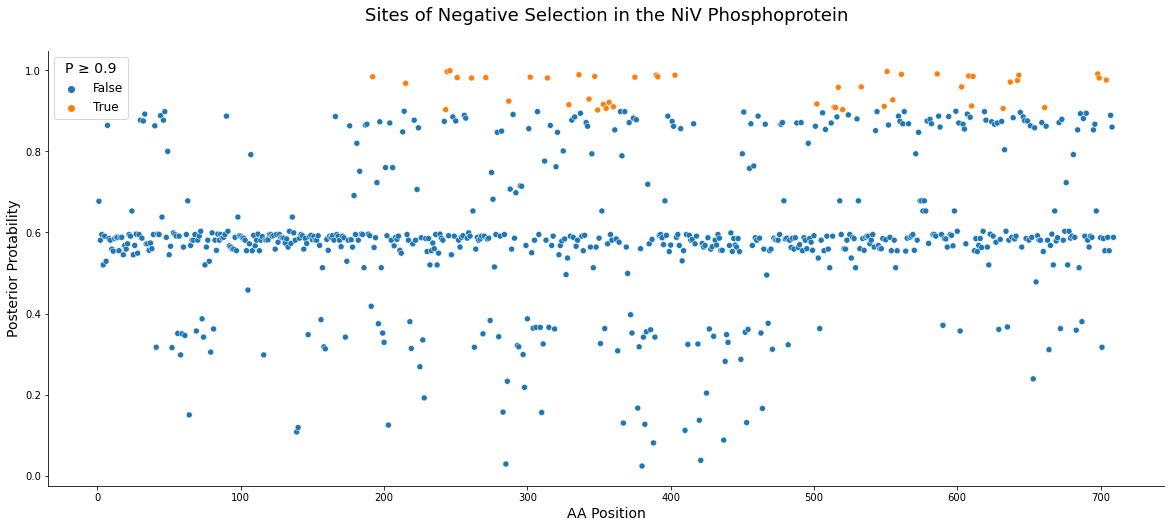

In [132]:
# P_fubar.columns = ["Site", "Partitions", "a", "b", "b-a", "P(a>b)", "P(a<b)", "Bayes_Factor(a<b)"]

P_fubar = pd.read_csv("hyphy/FUBAR/P_sites.csv")

# boolean variables for significant
P_fubar["sig_negative"] = (P_fubar["P(a>b)"] >= 0.9)
P_fubar["sig_positive"] = (P_fubar["P(a<b)"] >= 0.9)

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.scatterplot(data=P_fubar, x="Site", y="P(a>b)", hue="sig_negative", ax=ax)
sns.despine()

ax.set_title("Sites of Negative Selection in the NiV Phosphoprotein", fontsize=18, pad=30)
plt.xlabel("AA Position", fontsize=14)
plt.ylabel("Posterior Protability", fontsize=14)
plt.legend(title="P ≥ 0.9", title_fontsize=14, fontsize=12)
plt.savefig("hyphy/FUBAR/P_neg.png", dpi=250)

In [137]:
#P_fubar.loc[P_fubar["P(a>b)"] > 0.9]

560-592 = L protein binding

# STAT1 binding site???

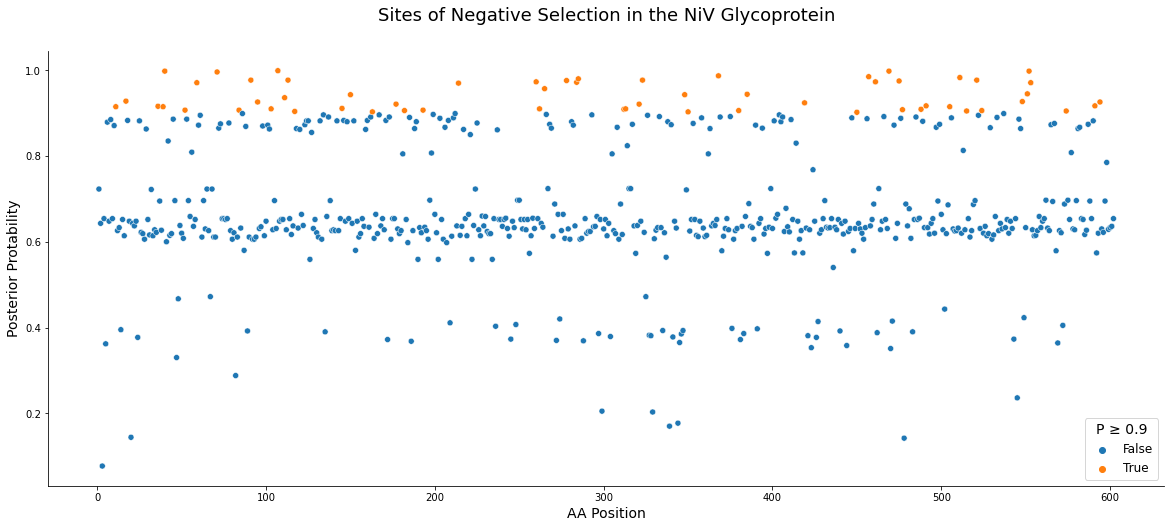

In [70]:
# G_fubar.columns = ["Site", "Partitions", "a", "b", "b-a", "P(a>b)", "P(a<b)", "Bayes_Factor(a<b)"]

G_fubar = pd.read_csv("hyphy/FUBAR/G_sites.csv")

# boolean variables for significant
G_fubar["sig_negative"] = (G_fubar["P(a>b)"] >= 0.9)
G_fubar["sig_positive"] = (G_fubar["P(a<b)"] >= 0.9)

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.scatterplot(data=G_fubar, x="Site", y="P(a>b)", hue="sig_negative", ax=ax)

ax.set_title("Sites of Negative Selection in the NiV Glycoprotein", fontsize=18, pad=30)
plt.xlabel("AA Position", fontsize=14)
plt.ylabel("Posterior Protability", fontsize=14)
plt.legend(title="P ≥ 0.9", title_fontsize=14, fontsize=12)
sns.despine()
plt.savefig("hyphy/FUBAR/G_neg.png", dpi=250)